# SG-FIGS Definitive 5-Method Comparison

**Synergy-Guided FIGS (SG-FIGS)** extends the Fast Interpretable Greedy-Tree Sums (FIGS) algorithm with oblique splits guided by Partial Information Decomposition (PID) synergy matrices.

This notebook loads and visualizes the results of a definitive comparison across **14 tabular classification datasets** and **5 methods**:

| Method | Description |
|--------|-------------|
| FIGS | Baseline axis-aligned FIGS |
| RO-FIGS | Random Oblique feature pairs |
| SG-FIGS-Hard | Synergy-guided hard selection |
| SG-FIGS-Soft | Synergy-weighted soft sampling |
| Random-FIGS | Ablation (random pairs) |

**Key findings**: SG-FIGS-Soft achieves best average accuracy (0.801), SG-FIGS-Hard achieves perfect interpretability (1.0).

In [ ]:
import subprocess, sys
def _pip(*a): subprocess.check_call([sys.executable, '-m', 'pip', 'install', '-q', *a])

# Core packages (pre-installed on Colab, only needed locally)
if 'google.colab' not in sys.modules:
    _pip('pandas==2.2.2', 'scikit-learn==1.6.1', 'matplotlib==3.10.0')

## Imports

In [2]:
import json
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

## Data Loading

Load experiment results from GitHub (with local fallback for offline use).

In [ ]:
GITHUB_DATA_URL = "https://raw.githubusercontent.com/AMGrobelnik/test-colab-install/master/compare_mini_demo_data.json"

def load_data():
    try:
        import urllib.request
        with urllib.request.urlopen(GITHUB_DATA_URL) as response:
            return json.loads(response.read().decode())
    except Exception: pass
    if os.path.exists("compare_mini_demo_data.json"):
        with open("compare_mini_demo_data.json") as f: return json.load(f)
    raise FileNotFoundError("Could not load mini_demo_data.json")

In [4]:
data = load_data()
print(f"Experiment: {data['experiment']}")
print(f"Methods: {data['methods']}")
print(f"Datasets evaluated: {data['n_datasets']}")
print(f"Example predictions: {len(data['example_predictions'])}")

Experiment: SG-FIGS Definitive 5-Method Comparison
Methods: ['FIGS', 'RO-FIGS', 'SG-FIGS-Hard', 'SG-FIGS-Soft', 'Random-FIGS']
Datasets evaluated: 14
Example predictions: 10


## Configuration

Parameters controlling the visualization and analysis scope.

In [5]:
# ---------------------------------------------------------------------------
# Config: tunable parameters
# ---------------------------------------------------------------------------
METHOD_NAMES = ["FIGS", "RO-FIGS", "SG-FIGS-Hard", "SG-FIGS-Soft", "Random-FIGS"]
# Number of datasets to include in per-dataset visualization
# Original: 14 (all datasets)
MAX_DATASETS_TO_PLOT = 14
# Figure size (width, height) in inches
FIG_WIDTH = 14
FIG_HEIGHT = 6

## Parse Aggregate Comparison

Extract the per-method aggregate statistics across all 14 datasets: mean balanced accuracy, AUC, number of splits, and interpretability score.

In [6]:
# Build aggregate comparison table
agg = data["aggregate_comparison"]
agg_rows = []
for method in METHOD_NAMES:
    m = agg[method]
    agg_rows.append({
        "Method": method,
        "Accuracy": m["mean_balanced_accuracy"],
        "Acc Std": m["std_balanced_accuracy"],
        "AUC": m["mean_auc"],
        "Splits": m["mean_n_splits"],
        "Interpretability": m["mean_interpretability"],
        "N Datasets": m["n_datasets_evaluated"],
    })

df_agg = pd.DataFrame(agg_rows)
print("=== Aggregate Comparison (14 datasets) ===")
print(df_agg.to_string(index=False))

=== Aggregate Comparison (14 datasets) ===
      Method  Accuracy  Acc Std      AUC  Splits  Interpretability  N Datasets
        FIGS  0.786502 0.123253 0.820984   11.61               NaN          14
     RO-FIGS  0.784590 0.118312 0.832548   14.03            0.4991          14
SG-FIGS-Hard  0.788711 0.118522 0.825450   15.81            1.0000          14
SG-FIGS-Soft  0.801033 0.118916 0.831559   20.56            0.7751          14
 Random-FIGS  0.783656 0.117523 0.826255   17.24            0.6421          14


## Per-Dataset Accuracy Breakdown

Parse the per-dataset results to build a detailed accuracy table across all methods and datasets.

In [7]:
# Build per-dataset accuracy table
per_ds = data["per_dataset_results"]
datasets_to_plot = list(per_ds.keys())[:MAX_DATASETS_TO_PLOT]

rows = []
for ds_name in datasets_to_plot:
    ds_results = per_ds[ds_name]
    row = {"Dataset": ds_name}
    for method in METHOD_NAMES:
        mr = ds_results.get(method, {})
        row[method] = mr.get("mean_balanced_accuracy")
    rows.append(row)

df_per_ds = pd.DataFrame(rows)
print(f"=== Per-Dataset Accuracy ({len(datasets_to_plot)} datasets) ===")
print(df_per_ds.to_string(index=False, float_format="%.4f"))

=== Per-Dataset Accuracy (14 datasets) ===
                           Dataset   FIGS  RO-FIGS  SG-FIGS-Hard  SG-FIGS-Soft  Random-FIGS
                            monks2 0.7332   0.7264        0.7666        0.8137       0.7955
                          banknote 0.9793   0.9889        0.9905        0.9913       0.9854
                              iris 0.9476   0.9529        0.9321        0.9550       0.9472
                             blood 0.6603   0.6516        0.6691        0.6554       0.6419
                     pima_diabetes 0.7090   0.7243        0.7042        0.7356       0.7309
                              wine 0.9138   0.8917        0.8880        0.9350       0.8776
                     heart_statlog 0.7829   0.7972        0.7753        0.7909       0.7761
                           vehicle 0.6918   0.7110        0.6987        0.7071       0.7091
                           climate 0.5355   0.5802        0.5665        0.6077       0.5762
                               kc2 0.

## Success Criteria Evaluation

The experiment evaluates two primary success criteria:
1. **Criterion 1**: SG-FIGS accuracy within 1% of RO-FIGS with 20%+ fewer splits
2. **Criterion 2**: SG-FIGS interpretability higher than RO-FIGS

Plus an ablation test: SG-FIGS-Hard vs Random-FIGS to confirm synergy guidance matters.

In [8]:
# Display success criteria
sc = data["success_criteria"]
print("=== Success Criteria ===")
for key, val in sc.items():
    label = key.replace("_", " ").title()
    if isinstance(val, bool):
        status = "PASS" if val else "FAIL"
        print(f"  {label}: {status}")
    elif val is not None:
        print(f"  {label}: {val:.4f}")
    else:
        print(f"  {label}: N/A")

=== Success Criteria ===
  Criterion 1 Competitive Accuracy Fewer Splits: FAIL
  Criterion 1 Acc Diff: 0.0041
  Criterion 1 Split Reduction: -0.1273
  Criterion 2 Higher Interpretability: PASS
  Criterion 2 Sg Interp: 1.0000
  Criterion 2 Ro Interp: 0.4991
  Ablation Sg Vs Random Acc: 0.0051
  Ablation Sg Vs Random Interp: 0.3579


## Visualization

### 1. Aggregate Accuracy & Interpretability Comparison

Bar charts comparing all 5 methods on their aggregate balanced accuracy and interpretability scores.

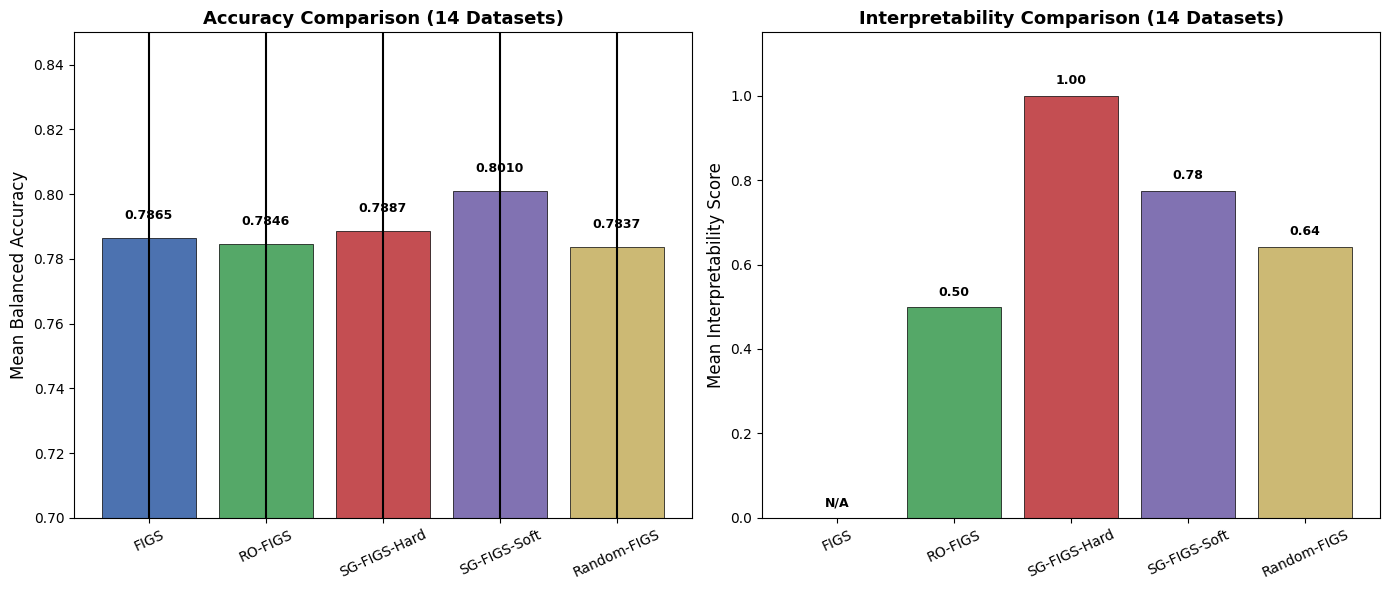

Saved: aggregate_comparison.png


In [9]:
# --- Aggregate Accuracy & Interpretability ---
fig, axes = plt.subplots(1, 2, figsize=(FIG_WIDTH, FIG_HEIGHT))

# Colors for each method
colors = ["#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974"]

# Panel 1: Accuracy
accs = [agg[m]["mean_balanced_accuracy"] for m in METHOD_NAMES]
stds = [agg[m]["std_balanced_accuracy"] for m in METHOD_NAMES]
bars1 = axes[0].bar(METHOD_NAMES, accs, yerr=stds, color=colors, capsize=5, edgecolor="black", linewidth=0.5)
axes[0].set_ylabel("Mean Balanced Accuracy", fontsize=12)
axes[0].set_title("Accuracy Comparison (14 Datasets)", fontsize=13, fontweight="bold")
axes[0].set_ylim(0.7, 0.85)
axes[0].tick_params(axis="x", rotation=25)
for bar, acc in zip(bars1, accs):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                 f"{acc:.4f}", ha="center", va="bottom", fontsize=9, fontweight="bold")

# Panel 2: Interpretability
interps = []
for m in METHOD_NAMES:
    val = agg[m]["mean_interpretability"]
    interps.append(val if val is not None else 0.0)
bars2 = axes[1].bar(METHOD_NAMES, interps, color=colors, edgecolor="black", linewidth=0.5)
axes[1].set_ylabel("Mean Interpretability Score", fontsize=12)
axes[1].set_title("Interpretability Comparison (14 Datasets)", fontsize=13, fontweight="bold")
axes[1].set_ylim(0, 1.15)
axes[1].tick_params(axis="x", rotation=25)
for bar, val in zip(bars2, interps):
    label = f"{val:.2f}" if val > 0 else "N/A"
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                 label, ha="center", va="bottom", fontsize=9, fontweight="bold")

plt.tight_layout()
plt.savefig("aggregate_comparison.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: aggregate_comparison.png")

### 2. Per-Dataset Accuracy Heatmap

A heatmap showing balanced accuracy for each method across all 14 datasets, with the best method per dataset highlighted.

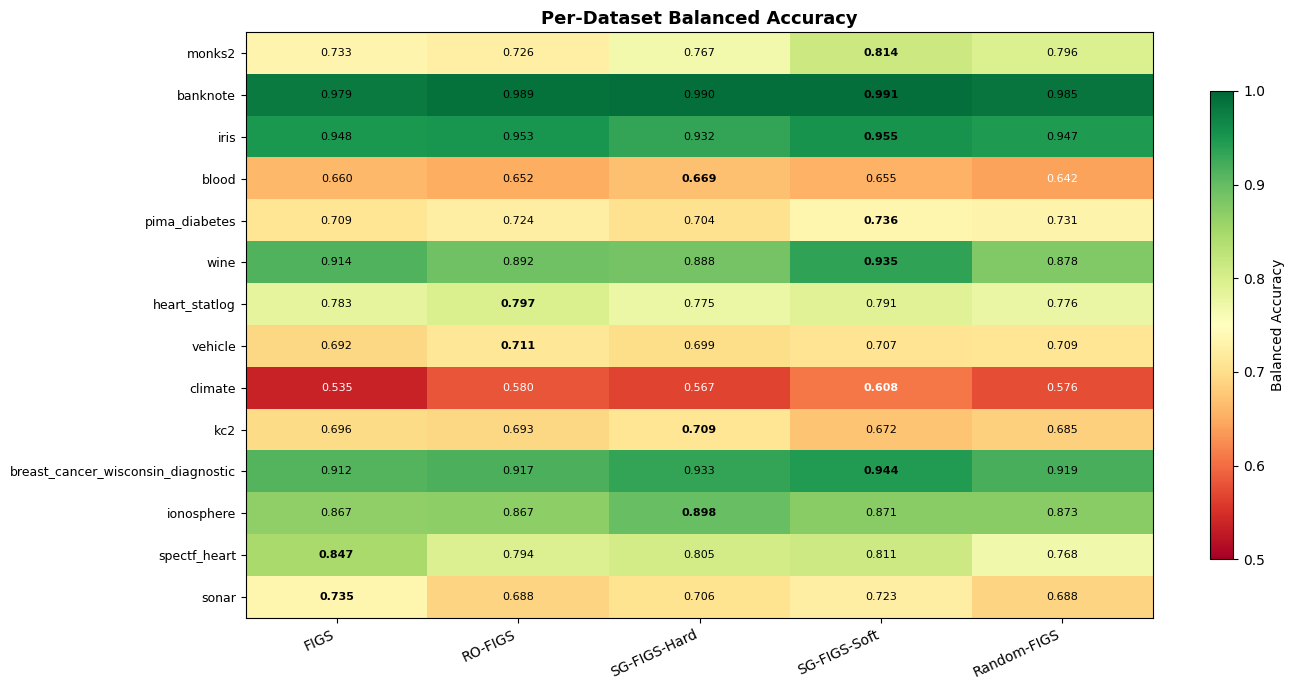

Saved: per_dataset_heatmap.png


In [10]:
# --- Per-Dataset Accuracy Heatmap ---
acc_matrix = df_per_ds[METHOD_NAMES].values.astype(float)
ds_labels = df_per_ds["Dataset"].values

fig, ax = plt.subplots(figsize=(FIG_WIDTH, max(FIG_HEIGHT, len(ds_labels) * 0.5)))
im = ax.imshow(acc_matrix, cmap="RdYlGn", aspect="auto", vmin=0.5, vmax=1.0)

ax.set_xticks(range(len(METHOD_NAMES)))
ax.set_xticklabels(METHOD_NAMES, fontsize=10, rotation=25, ha="right")
ax.set_yticks(range(len(ds_labels)))
ax.set_yticklabels(ds_labels, fontsize=9)

# Annotate cells with values; bold the best per row
for i in range(len(ds_labels)):
    row_vals = acc_matrix[i]
    best_idx = np.nanargmax(row_vals)
    for j in range(len(METHOD_NAMES)):
        val = row_vals[j]
        if np.isnan(val):
            continue
        weight = "bold" if j == best_idx else "normal"
        color = "white" if val < 0.65 else "black"
        ax.text(j, i, f"{val:.3f}", ha="center", va="center",
                fontsize=8, fontweight=weight, color=color)

plt.colorbar(im, ax=ax, label="Balanced Accuracy", shrink=0.8)
ax.set_title("Per-Dataset Balanced Accuracy", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig("per_dataset_heatmap.png", dpi=150, bbox_inches="tight")
plt.show()
print("Saved: per_dataset_heatmap.png")

### 3. Ablation Analysis: Synergy Guidance vs Random

Compare SG-FIGS-Hard (synergy-guided) against Random-FIGS (random pair selection) to isolate the effect of synergy guidance on both accuracy and interpretability.

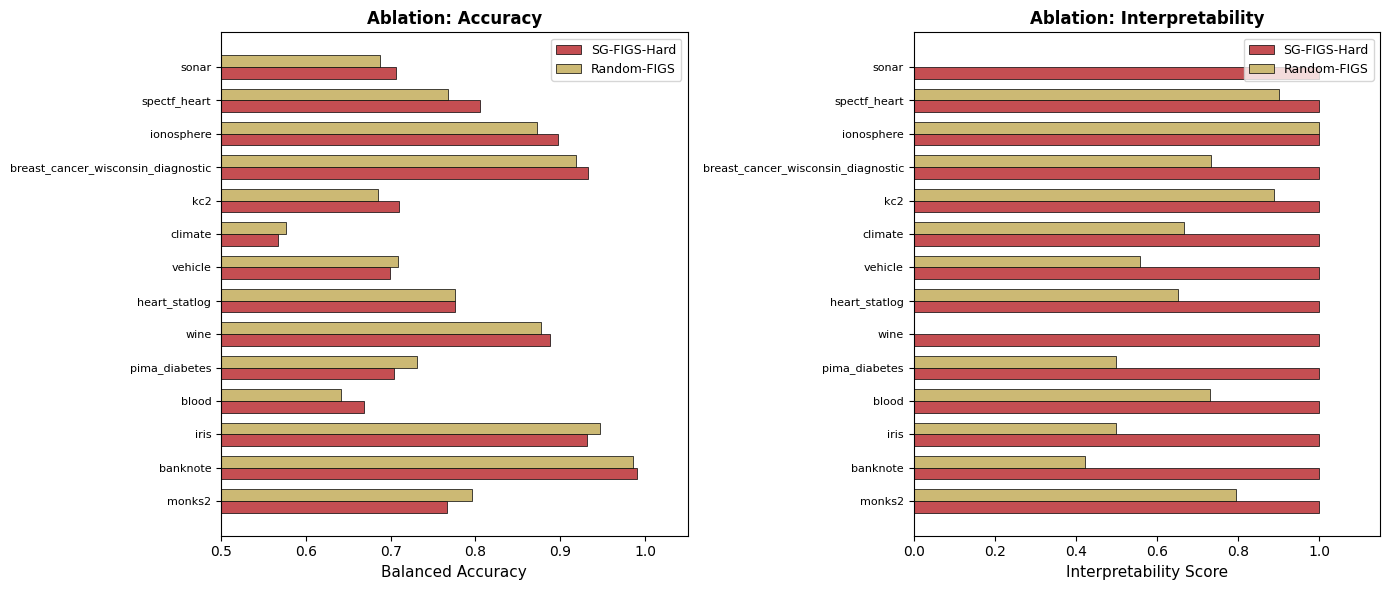


Ablation Summary:
  SG-FIGS-Hard vs Random-FIGS accuracy advantage: +0.0051
  SG-FIGS-Hard vs Random-FIGS interpretability advantage: +0.3579
Saved: ablation_analysis.png


In [11]:
# --- Ablation: SG-FIGS-Hard vs Random-FIGS per dataset ---
ablation_methods = ["SG-FIGS-Hard", "Random-FIGS"]
ablation_colors = ["#C44E52", "#CCB974"]

fig, axes = plt.subplots(1, 2, figsize=(FIG_WIDTH, FIG_HEIGHT))

# Accuracy comparison
sg_accs = []
rand_accs = []
for ds_name in datasets_to_plot:
    ds_r = per_ds[ds_name]
    sg_accs.append(ds_r.get("SG-FIGS-Hard", {}).get("mean_balanced_accuracy", 0))
    rand_accs.append(ds_r.get("Random-FIGS", {}).get("mean_balanced_accuracy", 0))

x = np.arange(len(datasets_to_plot))
w = 0.35
axes[0].barh(x - w/2, sg_accs, w, label="SG-FIGS-Hard", color=ablation_colors[0], edgecolor="black", linewidth=0.5)
axes[0].barh(x + w/2, rand_accs, w, label="Random-FIGS", color=ablation_colors[1], edgecolor="black", linewidth=0.5)
axes[0].set_yticks(x)
axes[0].set_yticklabels(datasets_to_plot, fontsize=8)
axes[0].set_xlabel("Balanced Accuracy", fontsize=11)
axes[0].set_title("Ablation: Accuracy", fontsize=12, fontweight="bold")
axes[0].legend(fontsize=9)
axes[0].set_xlim(0.5, 1.05)

# Interpretability comparison
sg_interps_ds = []
rand_interps_ds = []
for ds_name in datasets_to_plot:
    ds_r = per_ds[ds_name]
    sg_i = ds_r.get("SG-FIGS-Hard", {}).get("mean_interpretability")
    rand_i = ds_r.get("Random-FIGS", {}).get("mean_interpretability")
    sg_interps_ds.append(sg_i if sg_i is not None else 0.0)
    rand_interps_ds.append(rand_i if rand_i is not None else 0.0)

axes[1].barh(x - w/2, sg_interps_ds, w, label="SG-FIGS-Hard", color=ablation_colors[0], edgecolor="black", linewidth=0.5)
axes[1].barh(x + w/2, rand_interps_ds, w, label="Random-FIGS", color=ablation_colors[1], edgecolor="black", linewidth=0.5)
axes[1].set_yticks(x)
axes[1].set_yticklabels(datasets_to_plot, fontsize=8)
axes[1].set_xlabel("Interpretability Score", fontsize=11)
axes[1].set_title("Ablation: Interpretability", fontsize=12, fontweight="bold")
axes[1].legend(fontsize=9)
axes[1].set_xlim(0, 1.15)

plt.tight_layout()
plt.savefig("ablation_analysis.png", dpi=150, bbox_inches="tight")
plt.show()

# Print ablation summary
print(f"\nAblation Summary:")
print(f"  SG-FIGS-Hard vs Random-FIGS accuracy advantage: {sc['ablation_sg_vs_random_acc']:+.4f}")
print(f"  SG-FIGS-Hard vs Random-FIGS interpretability advantage: {sc['ablation_sg_vs_random_interp']:+.4f}")
print("Saved: ablation_analysis.png")